# Introduction

We are data analysts employeed by the NCAA. We were given the assigment to study the given dataset to find any noticeable trends that should be researched further. We are going to focus on the Academic Progress Rate (APR), which is a calculation based off how many athletes on a team remain academiclly elligible and with the university. Most of the data within the NCAA dataset is not gathered by the NCAA. In fact, almost all of it is gathered by the member schools, and then shared with the NCAA. However, some of this data has been directly gathered by the NCAA. The dataset can be found at this link https://www.ncaa.org/sports/2016/12/14/shared-ncaa-research-data.aspx. We will be attempting to answer the following four questions:

1. How have the retention rates for NCAA schools changed over the available data, from 2004 to 2019? We will be using all of the RET_Rate_XXXX columns where XXXX represents a different year for each column

2. Exploratory analysis: How many sports are fielded by each institution, and does that vary between NCAA divisions?  We will be using the SCL_UNITID and SCL_NAME columns as well as the Sport_Code and Sport_Name to analyse the counts of sports by each university. This is important to see if schools generally field the same number of sports or if there's drastic differences between schools and analyze what could be different from schools with a high number of sports and those with a low number.

3. What variables are the most positively correlated with multi-year APR, and can we accurately predict what a teams multi-year APR will be given other data? (regression). This will involve using linear regression on the whole dataset to determine which variables are significant.

4. Do Private or Public schools have better APR and academic eligibility rates? We will be using the multi-year APR and multi-year academic eligibility columns and SCL_PRIVATE column.

To start with though, we need to clean the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

In [2]:
raw_data = pd.read_csv('C:/Users/natha/OneDrive/Documents/GitHub/DIDA_325_Final-project/csvs/raw data.csv')
drops=[0,12,20,85]
raw_data.drop(raw_data.columns[drops], axis=1, inplace=True)


 #The columns we want to fill are the 83rd to 98th columns (0-indexed) so we are creating a list of their indices using the range function
cols_to_fill = list(range(82, 97)) 
raw_data.iloc[:, cols_to_fill] = raw_data.iloc[:, cols_to_fill].fillna(0)

null_counts = raw_data.isnull().sum()
null_counts = null_counts[null_counts > 0]

print(null_counts.sort_values(ascending=False))

D1_FB_CONF_19                     1578
ELIG_RATE_2004                     900
APR_RATE_2004_1000                 900
NUM_OF_ATHLETES_2004               900
RET_RATE_2004                      900
                                  ... 
MULTIYR_ELIG_RATE                   15
MULTIYR_APR_RATE_1000_CI            15
MULTIYR_APR_RATE_1000_RAW           15
MULTIYR_SQUAD_SIZE                  15
MULTIYR_APR_RATE_1000_OFFICIAL      15
Length: 71, dtype: int64


Columns at index 0,12,20, and 85 were completley empty, so we will drop those columns. Next, columns at index 82 to 97 are littered with empty values, according to the documentation empty values there should actually be zeros so we use the fillna function so any empty values are replaced with zeros. Finnally, we print which columns have null values, and how many null values they have, doing so allows us to make more informed descions on how to clean the rest of the dataset.

In [3]:

raw_data.drop(columns=['D1_FB_CONF_19'], inplace=True)
# we use the subset paramter to specify which columns we want to check for null values and drop the rows with null values in those columns. https://www.w3schools.com/python/pandas/ref_df_dropna.asp
clean_data=raw_data.dropna(subset=['MULTIYR_RET_RATE', 'MULTIYR_APR_RATE_1000_RAW', 'MULTIYR_APR_RATE_1000_CI', 'MULTIYR_APR_RATE_1000_OFFICIAL', 'MULTIYR_SQUAD_SIZE', 'MULTIYR_ELIG_RATE'])

The "D1_FB_CONF_19" column has a lot of empty values, and is very similar to the "CONFNAME" column, so we will drop the column as a whole. Lastly, any rows that have null values in any of the multi year statistics will be useless for us, so we can drop all of those rows.

The columns remaining are SCL_UNITID (int) which is the id for each column, SCL_NAME (character), the name for the university, Sport_Code (Cateogry) and Sport_Name (chategory) which represent the id and name of the respective sport, Academic_Year(category) the year for that row, SCL_DIV_19 (Category), and SCL_SUB_19 (Category) which represent the NCAA division and subdivision they play in. CONFNAME (character) is the schools conference they compete in. SL_HBCU (category) and SL_Private (category) which is a binary data that shows if a school is HBCU and if a school is private. Then there are MULTIYR_APR_RATE_1000_RAW, MULTIYR_APR_RATE_1000_CI, MULTIYR_APR_RATE_1000_OFFICIAL, MULTIYR_SQUAD_SIZE, MULTIYR_ELIG_RATE,MULTIYR_RET_RATE which are all numeric and represent multiyear academic stats. Then from each year from 2006-2019 there are APR_RATE_XXXX_1000, ELIG_RATE_XXXX, RET_RATE_XXX, NUM_OF_ATHLETES_XXXX which are all numeric and represent single year academic stats. There are a lot of each column these are which each category of column means

APR_Rate: Academic Progress Rate as calculated by the NCAA.

ELIG_RATE: Percentage of athletes on a team which are academically elligible to compete.

RET_RATE: Percenentage of athletes who remain on the team after a year (excluding gratuating seniors and transfers)

NUM_OF_ATHLETES/MULTIYR_SQUAD_SIZE: The number of athletes on a sports teams roster.

Finally from 2006-2020 there are PUB_AWARD_XX which are categorical values that display if a school got an academic award from the NCAA.

In [4]:
# This leaves us with the following dataset
clean_data.head()

,SCL_UNITID,SCL_NAME,SPORT_CODE,SPORT_NAME,ACADEMIC_YEAR,SCL_DIV_19,SCL_SUB_19,CONFNAME_19,SCL_HBCU,SCL_PRIVATE,...,PUB_AWARD_15,PUB_AWARD_14,PUB_AWARD_13,PUB_AWARD_12,PUB_AWARD_11,PUB_AWARD_10,PUB_AWARD_09,PUB_AWARD_08,PUB_AWARD_07,PUB_AWARD_06
0,100654,Alabama A&M University,1,Baseball,2019,1,2,Southwestern Athletic Conf.,Y,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100654,Alabama A&M University,2,Men's Basketball,2019,1,2,Southwestern Athletic Conf.,Y,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100654,Alabama A&M University,4,Football,2019,1,2,Southwestern Athletic Conf.,Y,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100654,Alabama A&M University,6,Men's Golf,2019,1,2,Southwestern Athletic Conf.,Y,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100654,Alabama A&M University,13,Men's Tennis,2019,1,2,Southwestern Athletic Conf.,Y,N,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


Data Analaysis

Question 2: How have the Retention Rates of NCAA Member Schools changed between 2004 and 2019? We will be using all of the RET_Rate_XXXX columns where XXXX represents a different year for each column. This is an important question to answer because if there is a trend in either the positive or negative direction, it is imperative that the NCAA is able to identify it. A decrease in retention rate would signify that academics for athletes across all of division one are decreasing and there needs to be a drastic change. An increase in retention rate will show that member instiutions are improving their focus on academics. Going into the question are assumption is there will not be a noticeable trend.

In [5]:
data=clean_data.copy()
#removing unnesecary columns
data_ret=data.drop(columns=[ 'MULTIYR_APR_RATE_1000_RAW', 'MULTIYR_APR_RATE_1000_CI',
       'MULTIYR_APR_RATE_1000_OFFICIAL', 'RAW_OR_CI', 'MULTIYR_SQUAD_SIZE',
       'MULTIYR_ELIG_RATE', 'MULTIYR_RET_RATE', 'APR_RATE_2019_1000',
       'ELIG_RATE_2019', 'NUM_OF_ATHLETES_2019',
       'APR_RATE_2018_1000', 'ELIG_RATE_2018',
       'NUM_OF_ATHLETES_2018', 'APR_RATE_2017_1000', 'ELIG_RATE_2017', 'NUM_OF_ATHLETES_2017', 'APR_RATE_2016_1000',
       'ELIG_RATE_2016', 'NUM_OF_ATHLETES_2016',
       'APR_RATE_2015_1000', 'ELIG_RATE_2015',
       'NUM_OF_ATHLETES_2015', 'APR_RATE_2014_1000', 'ELIG_RATE_2014',
        'NUM_OF_ATHLETES_2014', 'APR_RATE_2013_1000',
       'ELIG_RATE_2013', 'NUM_OF_ATHLETES_2013',
       'APR_RATE_2012_1000', 'ELIG_RATE_2012',
       'NUM_OF_ATHLETES_2012', 'APR_RATE_2011_1000', 'ELIG_RATE_2011',
       'NUM_OF_ATHLETES_2011', 'APR_RATE_2010_1000',
         'NUM_OF_ATHLETES_2010','ELIG_RATE_2010',
       'APR_RATE_2009_1000', 'ELIG_RATE_2009',
       'NUM_OF_ATHLETES_2009', 'APR_RATE_2008_1000', 'ELIG_RATE_2008',
       'NUM_OF_ATHLETES_2008', 'APR_RATE_2007_1000',
       'ELIG_RATE_2007', 'NUM_OF_ATHLETES_2007',
       'APR_RATE_2006_1000', 'ELIG_RATE_2006',
       'NUM_OF_ATHLETES_2006', 'APR_RATE_2005_1000', 'ELIG_RATE_2005',
       'NUM_OF_ATHLETES_2005', 'APR_RATE_2004_1000',
       'ELIG_RATE_2004',  'NUM_OF_ATHLETES_2004',
       'PUB_AWARD_20', 'PUB_AWARD_19', 'PUB_AWARD_18', 'PUB_AWARD_17',
       'PUB_AWARD_16', 'PUB_AWARD_15', 'PUB_AWARD_14', 'PUB_AWARD_13',
       'PUB_AWARD_12', 'PUB_AWARD_11', 'PUB_AWARD_10', 'PUB_AWARD_09',
       'PUB_AWARD_08', 'PUB_AWARD_07', 'PUB_AWARD_06','SCL_UNITID', 'SCL_NAME', 'SPORT_CODE', 'SPORT_NAME', 'ACADEMIC_YEAR',
       'SCL_DIV_19', 'SCL_SUB_19', 'CONFNAME_19', 'SCL_HBCU', 'SCL_PRIVATE'])

In [6]:
data_ret[['RET_RATE_2019', 'RET_RATE_2018', 'RET_RATE_2017', 'RET_RATE_2016',
       'RET_RATE_2015', 'RET_RATE_2014', 'RET_RATE_2013', 'RET_RATE_2012',
       'RET_RATE_2011', 'RET_RATE_2010', 'RET_RATE_2009', 'RET_RATE_2008',
       'RET_RATE_2007', 'RET_RATE_2006', 'RET_RATE_2005', 'RET_RATE_2004']].apply({"RET_RATE_2019":["mean","median","min","max"],
                                        "RET_RATE_2018":["mean","median","min","max"],
                                        "RET_RATE_2017":["mean","median","min","max"],

                                        "RET_RATE_2016":["mean","median","min","max"],
                                        "RET_RATE_2015":["mean","median","min","max"],
                                        "RET_RATE_2014":["mean","median","min","max"],
                                        "RET_RATE_2013":["mean","median","min","max"],
                                        "RET_RATE_2012":["mean","median","min","max"],
                                        "RET_RATE_2011":["mean","median","min","max"],
                                        "RET_RATE_2010":["mean","median","min","max"],
                                        "RET_RATE_2009":["mean","median","min","max"],
                                        "RET_RATE_2008":["mean","median","min","max"],
                                         "RET_RATE_2007":["mean","median","min","max"],
                                         "RET_RATE_2006":["mean","median","min","max"],
                                         "RET_RATE_2005":["mean","median","min","max"],
                                         "RET_RATE_2004":["mean","median","min","max"]})

,RET_RATE_2019,RET_RATE_2018,RET_RATE_2017,RET_RATE_2016,RET_RATE_2015,RET_RATE_2014,RET_RATE_2013,RET_RATE_2012,RET_RATE_2011,RET_RATE_2010,RET_RATE_2009,RET_RATE_2008,RET_RATE_2007,RET_RATE_2006,RET_RATE_2005,RET_RATE_2004
mean,0.977916,0.977561,0.977910,0.977246,0.975696,0.975297,0.973303,0.970338,0.969084,0.967932,0.967932,0.965953,0.955539,0.953580,0.952880,0.952737
median,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.983471,0.980769,0.980392,0.980066,0.977778,0.965517,0.962963,0.962963,0.962963
min,0.571429,0.555556,0.727273,0.444444,0.666667,0.636364,0.714286,0.666667,0.680000,0.666667,0.555556,0.684211,0.571429,0.631579,0.571429,0.611111
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
data_ret.mean()

RET_RATE_2019    0.977916
RET_RATE_2018    0.977561
RET_RATE_2017    0.977910
RET_RATE_2016    0.977246
RET_RATE_2015    0.975696
RET_RATE_2014    0.975297
RET_RATE_2013    0.973303
RET_RATE_2012    0.970338
RET_RATE_2011    0.969084
RET_RATE_2010    0.967932
RET_RATE_2009    0.967932
RET_RATE_2008    0.965953
RET_RATE_2007    0.955539
RET_RATE_2006    0.953580
RET_RATE_2005    0.952880
RET_RATE_2004    0.952737
dtype: float64

From examining the means of yearly retention rates, spanning 2004 to 2019, we are able to see a trend of retention rates improving year over year. This indicates that as a whole, NCAA member schools are improving their rentention, and therefore improving as schools. While this change is small, it still implies that the quality of education in member schools is increasing, causing more students to stay.

Visual Representation

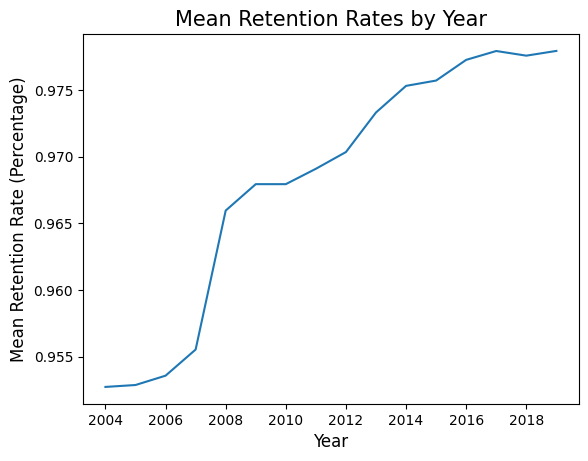

In [8]:
#This stores the means for each year's retention rates, associated with the correct year for the purposes of data visualization
meanslist = {'year': [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019], 're_mean': [0.952737,0.952880,0.953580,0.955539,0.965953,0.967932,0.967932,0.969084,0.970338,0.973303,0.975297,0.975696,0.977246,0.977910,0.977561,0.977916]}
meansframe = pd.DataFrame(meanslist)

sns.lineplot(meansframe, x='year', y='re_mean')
plt.title("Mean Retention Rates by Year", fontsize=15)
plt.ylabel("Mean Retention Rate (Percentage)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.show()

From this graph it can be confirmed that retention rates appear to be increasing year over year in NCAA member schools.

Conclusion
From the retention rates alone, it would appear that the quality of NCAA member schools is increasing. Retention rate means have increased year over year, with no recorded drops between 2004 and 2019. A higher mean retention rate indcates that overall, more students are staying at their schools

Question 3: What variables are the most positively correlated with multi-year APR, and can we accurately predict what a teams multi-year APR will be given other data? (regression). This will involve using linear regression on the whole dataset to determine which variables are significant.

There are a couple of reasons why this is an important question to answer. One being that if the NCAA can predict what teams will have a higher or lower APR it knows which schools and sports it can provide athletes with more resources to help the students. Additionally if the NCAA knows which factors are most important for predicting APR they can know exactly how to help their athletes. Before answering the question I do beleive we'll be able to train a linear regression model that does a strong job at predicting APR, additionally I beleive multi year retention rates and multi year eligibility rates will be the two strongest variables in prediciting APR.


In [9]:
# Creating a copy of the dataset to work with this specific research qeustion
data=clean_data.copy()
x_columns=['SCL_HBCU', 'SCL_PRIVATE', 'MULTIYR_SQUAD_SIZE', 'SCL_SUB_19', 'MULTIYR_ELIG_RATE', 'MULTIYR_RET_RATE'] 
X=data[x_columns] 
X = pd.get_dummies(X, drop_first=True).astype("float32") #
y=data['MULTIYR_APR_RATE_1000_OFFICIAL'] 
X = sm.tools.tools.add_constant(X) 
model=sm.OLS(y, X).fit() 
print(model.summary())

                                  OLS Regression Results                                  
Dep. Variable:     MULTIYR_APR_RATE_1000_OFFICIAL   R-squared:                       0.896
Model:                                        OLS   Adj. R-squared:                  0.896
Method:                             Least Squares   F-statistic:                     8643.
Date:                            Thu, 01 May 2025   Prob (F-statistic):               0.00
Time:                                    15:11:20   Log-Likelihood:                -18418.
No. Observations:                            6002   AIC:                         3.685e+04
Df Residuals:                                5995   BIC:                         3.690e+04
Df Model:                                       6                                         
Covariance Type:                        nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---

From the model summary we can see that "MULTIYR_SQUAD_SIZE", "MULTIYR_ELIG_RATE", "MULTIYR_RET_RATE", and "SCL_HCBU_Y" are all signifiicant variables as their p-values round to zero and using the coefficients we can gleam the following

MULTIYR_SQUAD_SIZE:
Every additional 1 person added to the squad size decreases the APR score by 0.0156 points, on average, holding other variables constant.

MULTIYR_ELIG_RATE:
Every 1.0 (or 100 percentage points) increase in eligibility rate would increase APR by 424.32 points. More realistically, a 1% increase (i.e., +0.01) in eligibility rate would increase APR by about 4.24 points.

MULTIYR_RET_RAT:
Every 1.0 (or 100 percentage points) increase in retention rate would increase APR by 420.22 points. So a 1% increase (i.e., +0.01) in retention rate would increase APR by about 4.20 points.

SCL_HBCU_Y:
If a school is an HBCU (coded as 1), then the APR is higher by about 1.92 points compared to non-HBCUs (coded as 0), holding everything else constant.

Additiionally with an R^2 of about 0.896 we can say that 89.6% of the variance of APR can be explained by SCL_HBCU', 'SCL_PRIVATE', 'MULTIYR_SQUAD_SIZE', 'SCL_SUB_19', 'MULTIYR_ELIG_RATE',  and 'MULTIYR_RET_RATE'. With the model we can predict APR scores decently accurately, compared to simply guessing the mean APR, and about 90% of those prediction improvement come from these six variables.

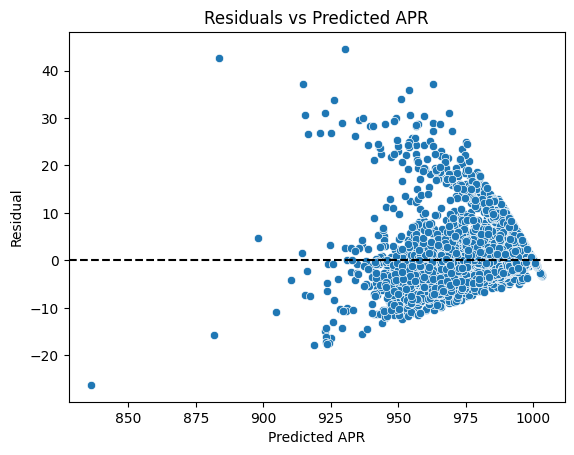

In [10]:
yhat = model.predict()
residuals = y - yhat
ax = sns.scatterplot(x=yhat, y=residuals)
ax.axhline(y=0, color='black', linestyle='dashed')

plt.xlabel("Predicted APR")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted APR")
plt.show()

There do not seem to be any trends with the residuals, which is a good thing for our model.

# Question Conclusion

Based off of the high R squared value it is possible to use a linear regression model to accurately predict APR rates. We accurately predicted that high retention rates and high eligibility rates would be significant variables, and strongly positvely correlated with higher APR rates. However, we underestimated just how significant the size of a team and if a school was HBCU or not would be on predicting APR. 

If the NCAA wanted to know a schools APR but did not have access to the final APR calculation yet they could use the formula:

and 90% of the variance in APR would be contained within the formula.The NCAA could then use this data to know what schools to funnel resources to and help their athletes. Based on our findings it woud also know to focus on retention rates and eligibility rates to improve APR, in addition to giving an increased help to schools with large roster size and HBCUs.